In [1]:
import tqdm
import scipy.stats

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

In [2]:
# Load feature linker data
fl_file = "results/process_feature_output_formatting_openms/output_start_parameter_worked_9_FL_param_QT_3/linked_features_quantification.tsv"
fl_df = pd.read_csv(fl_file,sep="\t")

In [3]:
# Extracting native mz and rt
# Also the met id for the native compounds for later use from the fl_file
found_feature_file = "found_features.csv"
IS_df = pd.read_csv(found_feature_file).round(5)
mz_native,rt_native = [],[]
for index,row in IS_df.iterrows():
    if row["cmpd_type"].lower() == "native":
        mz_native.append(row["mz_fl"])
        rt_native.append(row["rt_fl"])
        
native_metid = []
for index, row in tqdm.tqdm(fl_df.iterrows()):
    rt_cf = row["rt_cf"]
    mz_cf = row["mz_cf"]
    for mz,rt in zip(mz_native,rt_native):
        if abs(rt_cf - rt) <= 0.00001 and abs(mz_cf - mz) <= 0.00001:
            native_metid.append(row["Met_ID"])

39538it [00:01, 32186.64it/s]


In [4]:
# Select only the intensity column and the data from the FL file
selected_columns = []
for columns in list(fl_df.columns):
    if "Met_ID" in columns or "intensity_Sample" in columns:
        selected_columns.append(columns)
        
col_select_df = fl_df[selected_columns]
col_select_df.replace(np.nan, -1,inplace=True)

/tmp/ipykernel_13794/2677488686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_select_df.replace(np.nan, -1,inplace=True)


In [5]:
# Select features with coverage cutoff
coverage_cutoff = 0.90

row_names = []
selected_row_index = []
for index, row in tqdm.tqdm(col_select_df.iterrows()):
    non_zero_count,zero_count = 0,0
    for value in row.to_list()[1:]:
        if value > 0:
                non_zero_count += 1
        else:
            zero_count += 1
    coverage = non_zero_count/(non_zero_count+zero_count)
    if coverage >= coverage_cutoff:
        selected_row_index.append(index)
        row_names.append(str(int(row["Met_ID"])) + " (" + str(round(coverage*100,4)) + "%)")
        
row_col_select_df = col_select_df.iloc[selected_row_index]
row_col_select_df.replace(-1,np.nan,inplace=True)
print ("Total number of data points with the coverage cutoff = " + str(len(row_col_select_df)))

39538it [00:00, 43996.47it/s]


Total number of data points with the coverage cutoff = 4939


/tmp/ipykernel_13794/2475947781.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_col_select_df.replace(-1,np.nan,inplace=True)


In [6]:
# Renaming and transposing the data and keeping only the necessary columns
row_col_select_df_renamed = row_col_select_df.set_axis(row_names, axis=0, inplace=False)
row_col_select_df_renamed = row_col_select_df_renamed.T
row_col_select_df_renamed.drop(["Met_ID"],axis=0,inplace=True)

In [7]:
# Calculating correlation
row_col_select_df_renamed[row_col_select_df_renamed.columns.to_list()] = row_col_select_df_renamed[row_col_select_df_renamed.columns.to_list()].apply(pd.to_numeric, errors='coerce')
cr_matrix=row_col_select_df_renamed.corr(method="pearson",min_periods=2)

In [8]:
# Converting to dissimilarity matrix
# Then using a cutoff for clustering
correlation_cutoff = 0.6

dissimilarity = 1 - np.abs(cr_matrix)
hierarchy = linkage(squareform(dissimilarity), method='average')
labels = fcluster(hierarchy, 1-correlation_cutoff, criterion='distance')
print ("Total number of clusters " + str(len(set(labels))))

Total number of clusters 1715


In [9]:
met_id_in_cr = [int(columns.split("(")[0]) for columns in cr_matrix.columns.to_list()] # get the metid in the correlation matrix
native_id_in_cr = [nid for nid in native_metid if nid in met_id_in_cr] # get the native id in the correlation matrix
native_id_labels_dict = {nid:labels[met_id_in_cr.index(nid)] for nid in native_id_in_cr} # Find the label id (from the clustering) for the native id

In [11]:
# making dict of label and the corresponding keys as values
label_native_id_dict = {label:[] for label in list(native_id_labels_dict.values())}
for selected_label in label_native_id_dict:
    for i,label in enumerate(labels):
        if label == selected_label:
            label_native_id_dict[selected_label].append(met_id_in_cr[i])

In [12]:
# count number of items in each cluster
total = 0
for entry in list(label_native_id_dict.values()):
    total +=  (len(entry))
    print (len(entry))
print ("\nTotal number = " + str(total))

5
12
2
2

Total number = 21


In [2]:
'''
output =[]
for key in label_native_id_dict:
    if len(label_native_id_dict[key]) <= 50:
        output.extend (label_native_id_dict[key])
        print (key,label_native_id_dict[key])
'''

In [15]:
# Selecting rt and mz for the output of the clustering
output_file_selected_columns = ["Met_ID","rt_cf","mz_cf","intensity_cf"]
fl_df_subset = fl_df[output_file_selected_columns]
fl_df_subset["label"] = 0

/tmp/ipykernel_13794/2844886849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_df_subset["label"] = 0


In [17]:
# Writing output with a label column showing the same cluster
output_filename = "analysis_results/coverage" + str(coverage_cutoff) + "_correlation" + str(correlation_cutoff) + ".csv"

for label in label_native_id_dict:
    for met_id in label_native_id_dict[label]:
        fl_df_subset.loc[fl_df_subset['Met_ID'] == met_id, 'label'] = int(label)
        try:
            fl_df_subset.loc[fl_df_subset['Met_ID'] == met_id, 'real_name'] = IS_df[IS_df["met_id"] == met_id]["cmpd_name"].to_list()[0]
        except:
            pass
selected_fl_df_subset = fl_df_subset[fl_df_subset["label"] > 0]
selected_fl_df_subset.to_csv(output_filename)

/tmp/ipykernel_13794/2838901717.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_df_subset.loc[fl_df_subset['Met_ID'] == met_id, 'real_name'] = IS_df[IS_df["met_id"] == met_id]["cmpd_name"].to_list()[0]


In [19]:
# Plotting the selected cluster labels
# Get met_id from the selected labels
met_id_lists = []
for lists in list(label_native_id_dict.values()):
    met_id_lists.extend(lists)
    
# Rename the met_id with coverage 
met_id_lists_renamed = []
for entry in row_col_select_df_renamed.columns.to_list():
    if int(entry.split("(")[0]) in met_id_lists:
        met_id_lists_renamed.append(entry)
        
# Select the columns with selected met_id
clustered_met_id_intensity_df = row_col_select_df_renamed[met_id_lists_renamed].apply(pd.to_numeric, errors='coerce')
clustered_met_id_intensity_df

,102 (100.0%),173 (100.0%),314 (100.0%),527 (100.0%),1025 (100.0%),1069 (100.0%),1673 (100.0%),1772 (100.0%),1981 (100.0%),2991 (99.0%),...,3207 (98.0%),3480 (97.0%),3613 (97.0%),3842 (96.0%),3948 (95.0%),4170 (94.0%),4176 (94.0%),4424 (93.0%),4534 (92.0%),4862 (90.0%)
intensity_Sample34.mzML,198868.1,106176.10,1574306.00,4226945.0,115229.70,740635.0,1386154.0,106905.60,361408.5,811512.10,...,139000.10,45841.24,110583.80,28140.02,77396.36,72791.81,71485.51,33982.520000,164951.40,93466.62
intensity_Sample21.mzML,808014.4,273820.40,276963.40,4641538.0,184077.80,1752639.0,1509398.0,241298.10,814127.0,99585.97,...,160414.20,45574.13,32877.69,NaN,157368.80,167046.50,89090.74,167455.200000,114215.60,44354.80
intensity_Sample13.mzML,135769.5,73527.16,412704.20,1362407.0,252261.70,467686.4,464042.2,121118.50,424195.7,319244.00,...,51861.05,20579.91,89101.11,22488.41,112164.80,41663.23,102269.00,14899.800000,72775.05,46292.02
intensity_Sample25.mzML,181576.3,104412.20,111106.80,1537617.0,81309.87,659332.2,313659.2,63533.07,188811.4,172467.50,...,29937.84,40263.75,21403.47,33265.34,25817.18,98485.38,93177.67,30760.680000,67408.28,NaN
intensity_Sample55.mzML,547804.1,147933.60,211610.40,3668194.0,75841.59,2950825.0,975518.1,237963.20,747327.6,65540.72,...,126644.20,NaN,57799.41,10920.41,75730.56,102581.50,NaN,111063.200000,NaN,22196.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
intensity_Sample98.mzML,146985.4,61183.67,1689961.00,2330889.0,324870.80,848023.4,981974.3,153535.30,456301.3,421081.80,...,108567.50,31042.56,45638.65,17920.52,304009.00,33510.22,90605.49,7429.933594,87417.47,48515.56
intensity_Sample9.mzML,272148.2,119754.50,132087.30,3282278.0,42519.30,475230.9,680938.6,70494.54,235276.4,298180.10,...,64822.67,41881.22,24044.76,23874.34,169910.00,74302.83,28323.80,40348.840000,69231.25,15004.74
intensity_Sample77.mzML,150320.6,64251.27,975100.40,1738725.0,104350.40,840197.0,858656.1,230800.10,672409.9,172993.50,...,84838.68,23444.37,62325.06,59314.28,49808.37,22176.26,98445.82,25146.400000,68343.33,18423.44
intensity_Sample64.mzML,190205.0,108607.70,3265917.00,3241543.0,224524.40,4553334.0,1155686.0,110233.70,344306.4,193500.10,...,156095.10,44402.93,50882.99,94723.39,51968.76,107196.20,21737.67,39872.730000,38243.48,35482.10


In [20]:
from scipy.stats import pearsonr

# Creating correlation matrix and the p-values
def get_person_corr(arr1,arr2):
    condition = (arr1 != "None") & (arr2 != "None")
    condition = (arr1 != "nan") & (arr2 != "nan")
    if np.sum(condition) > 2:
        a1 = arr1[condition].astype('float64')
        b1 = arr2[condition].astype('float64')
        return (pearsonr(a1, b1))
    else:
        return (0,1)
    
corr_matrix = np.zeros((clustered_met_id_intensity_df.shape[1],clustered_met_id_intensity_df.shape[1]))
pval_matrix = np.zeros((clustered_met_id_intensity_df.shape[1],clustered_met_id_intensity_df.shape[1]))
pval_matrix_symbol = np.zeros((clustered_met_id_intensity_df.shape[1],clustered_met_id_intensity_df.shape[1])).astype('str')

for i,column1 in enumerate(clustered_met_id_intensity_df):
    for j,column2 in enumerate(clustered_met_id_intensity_df):
        np_arr1 = np.array(clustered_met_id_intensity_df[column1].to_list()).astype('str')
        np_arr2 = np.array(clustered_met_id_intensity_df[column2].to_list()).astype('str')
        corr,pval = get_person_corr(np_arr1,np_arr2)
        
        pval_rep = "\n"
        for value in [0.001,0.01,0.05]:
            if pval <= value:
                pval_rep += "*"
                
        pval_matrix_symbol[i,j] = pval_rep
        pval_matrix_symbol[j,i] = pval_rep
        corr_matrix[i,j] = corr
        corr_matrix[j,i] = corr
        
        pval_matrix[i,j] = pval
        pval_matrix[j,i] = pval

corr_matrix_with_pval = np.char.add(corr_matrix.round(2).astype("str"), pval_matrix_symbol.astype("str"))

In [ ]:
# Creating a correlation df
column_label = clustered_met_id_intensity_df.columns.to_list()
column_label_renamed = [] # Changing to native abbreviation if available
for entry in column_label:
    column_name = selected_fl_df_subset[selected_fl_df_subset["Met_ID"] == int(entry.split()[0])]["real_name"].to_list()[0]
    if str(column_name) != "nan":
        column_label_renamed.append(column_name + " " + entry.split()[1])
    else:
        column_label_renamed.append(entry)
        
df = pd.DataFrame.from_records(corr_matrix,columns=column_label_renamed)
df.set_axis(column_label_renamed, axis=0,inplace=True)

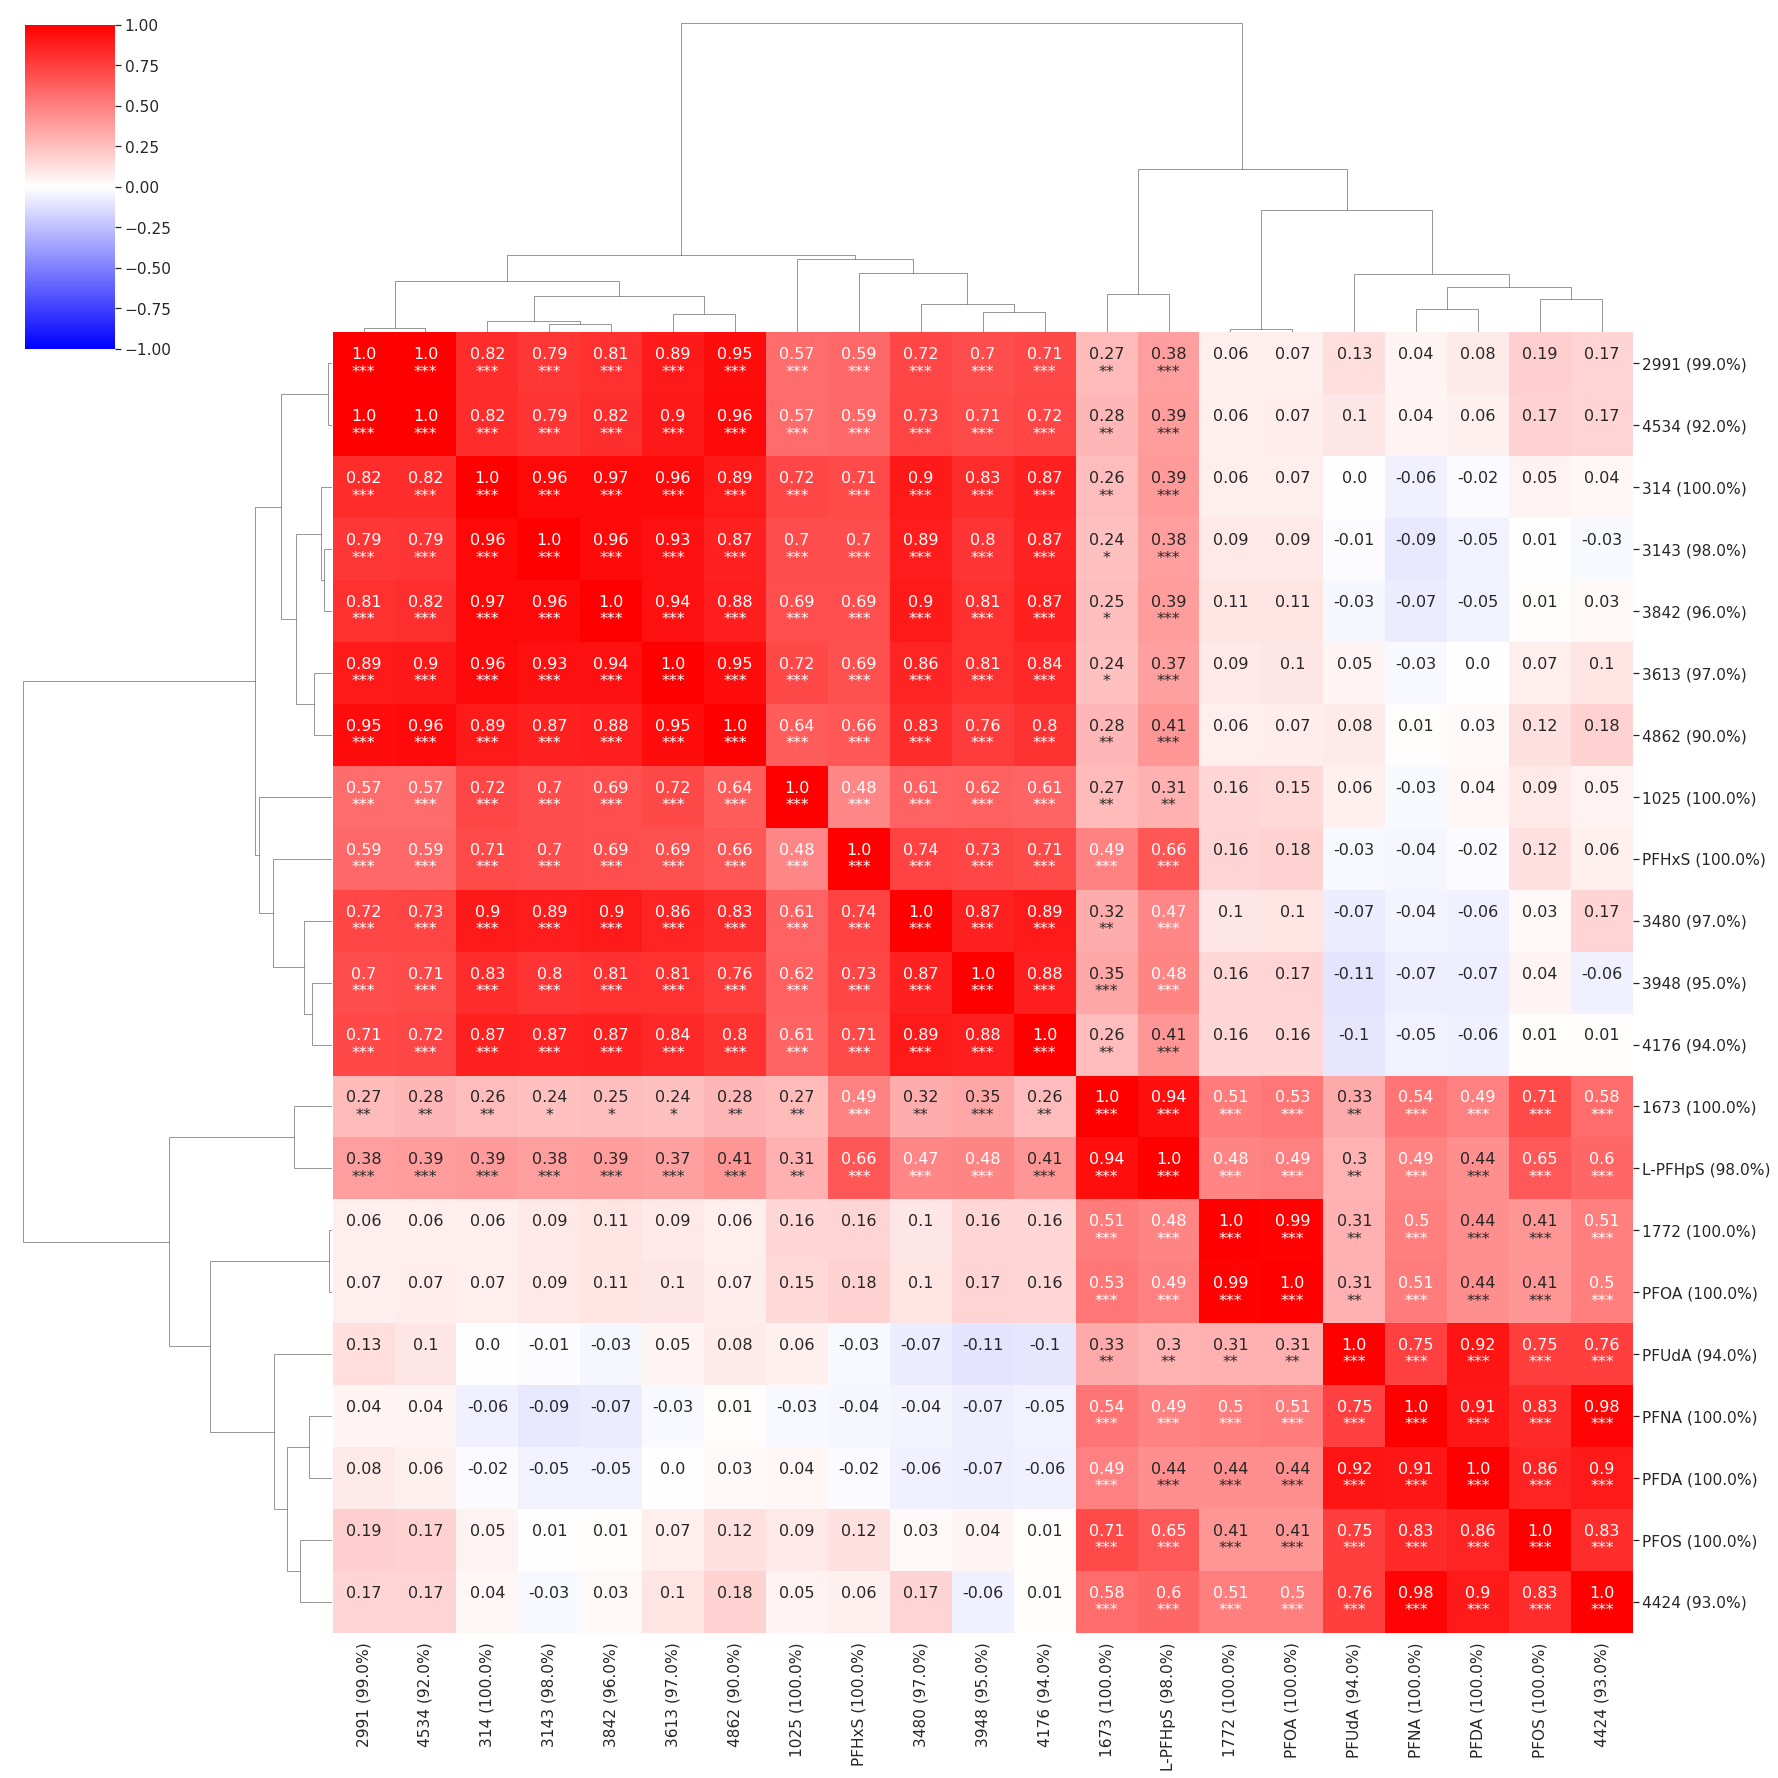

In [36]:
sns.set(font_scale=1.4)
cluster_map = sns.clustermap(df, method="complete", cmap='bwr', 
               annot_kws={"size": 16}, vmin=-1, vmax=1, figsize=(25,25),annot=corr_matrix_with_pval,fmt="");

In [37]:
cluster_map.figure.savefig(output_filename[:-4] + ".pdf",dpi=600)